# Time series analysis on air passenger data using ARIMA


In [1]:
file = "C:\\Users\\vidya\\Downloads\\AirPassengers.csv"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv(file)
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [4]:
#making month as date time index
from datetime import datetime
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [5]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


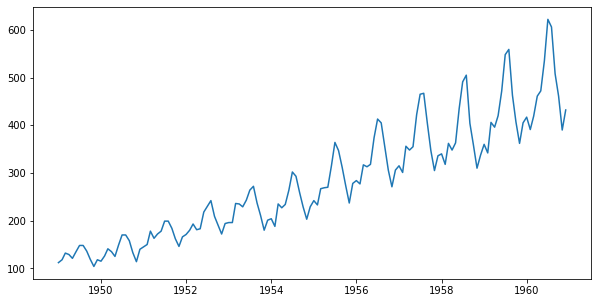

In [6]:
#lets see how our time series looks like.
ts=data["#Passengers"]
print(ts.head())
plt.figure(figsize=(10,5))
plt.plot(ts)
plt.show()

#terms to understand here

STATIONARITY

This is a very important concept in Time Series Analysis. In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series. There are a lot of statistical theories to explore stationary series than non-stationary series. (Thus we can bring the fight to our home ground!)

In practice we can assume the series to be stationary if it has constant statistical properties over time and these properties can be:
• constant mean
• constant variance
• an auto co-variance that does not depend on time.

These details can be easily retrieved using stat commands in python.

It’s clear from the plot that there is an overall increase in the trend,with some seasonality in it.

I have written a function for it as I will be using it quite often in this Time series explanation. But before we get to that,let me explain all the concepts in the function.

Plotting Rolling Statistics :The function will plot the moving mean or moving Standard Deviation. This is still visual method
NOTE: moving mean and moving standard deviation — At any instant ‘t’, we take the mean/std of the last year which in this case is 12 months)



Dickey-fuller Test :This is one of the statistical tests for checking stationarity. First we consider the null hypothesis: the time series is non- stationary. The result from the rest will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary (the force is strong with this one !!)


In [7]:
#function

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #pd.rolmean
    
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.figure(figsize=(12,7))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


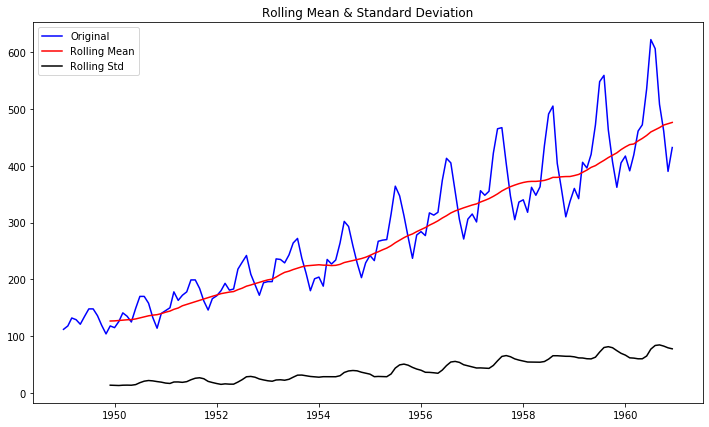

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
test_stationarity(ts)

# Time series is NOT stationary beacuse:

1.Since Test statistics is greater than critical value,so timeseries is not stationary.  
2.Mean is creasing with time and std is decreasing,both are not constant.


# Lets try to make TS as stationary
There are two major factors that make a time series non-stationary. They are:

• Trend: non-constant mean

• Seasonality: Variation at specific time-frames

The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated.

# Trend
The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.


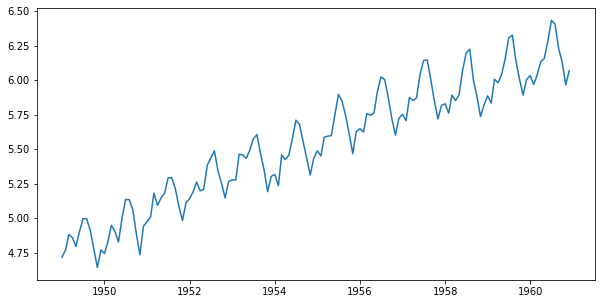

In [9]:
#log transformation of data
ts_log=np.log(ts)
plt.figure(figsize=(10,5))
plt.plot(ts_log)
plt.show()

we can see that there is a noise in data, we can smooth it using moving average

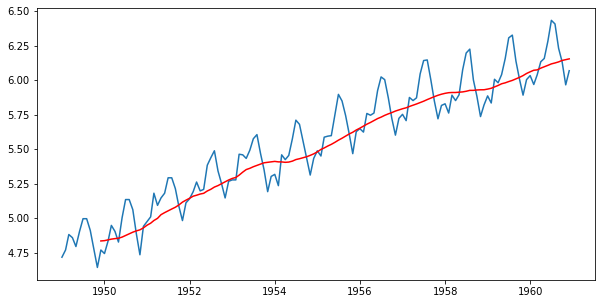

In [10]:
moving_avg=ts_log.rolling(12).mean()
plt.figure(figsize=(10,5))
plt.plot(ts_log)
plt.plot(moving_avg,color="r")
plt.show()

In [11]:
#there is still noise in the begining of the trend.
#lets make the series stationary
ts_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64

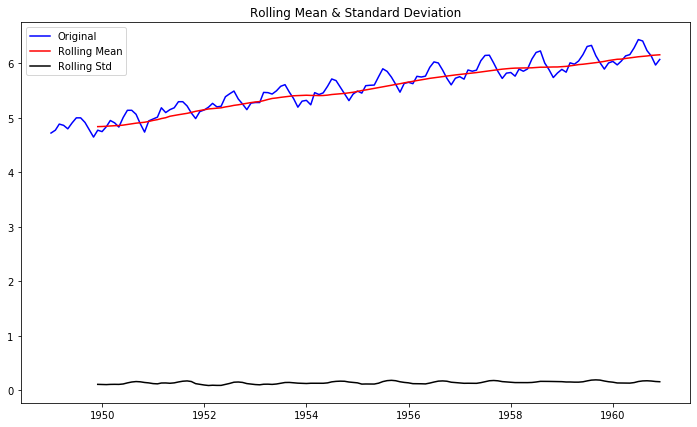

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [64]:
test_stationarity(ts_log)

# AR-Auto regression model

In [62]:
ts_log_shift=ts_log.shift(3)#shifting the data by one

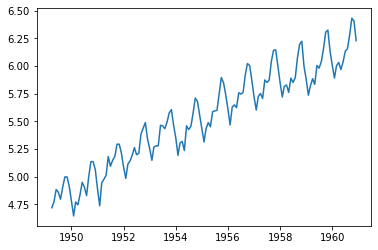

In [54]:
plt.plot(ts_log_shift)

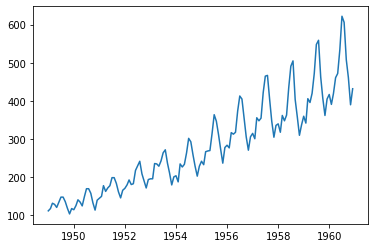

In [14]:
plt.plot(ts)

In [123]:
#make it stationary
ts_new=ts_log-ts_log.shift(1)
ts_data=ts_new[1:]
train= ts_data[1:100]
test=ts_data[100:]
print(train.size,test.size)

99 43


In [17]:
#AR(p) I(d) MA(q)
#acf is used to find the value of qtouching blue cloud whoch is a central limit and touching point decideds the q value.
#pacf is used to identify the value of p with same approach

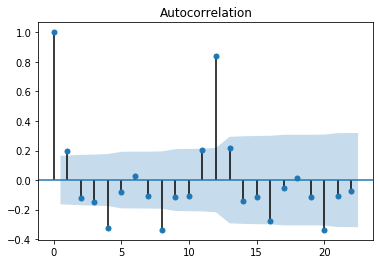

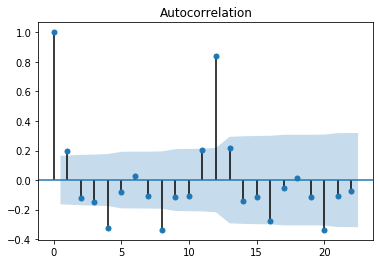

In [125]:
#ACF plot to see the autocorrelation factor of the data to see if the time series is stationary
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(ts_data) #q value of 14

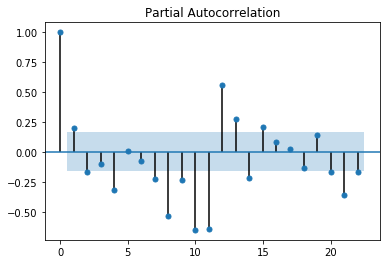

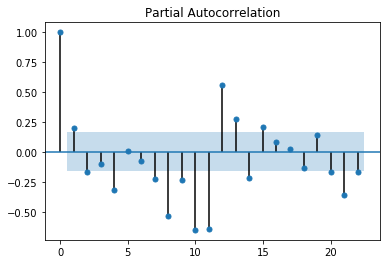

In [126]:
plot_pacf(ts_data)  #p value of 4 will work

In [127]:
#AR model:Auto regressive means y(t)=b0+b1*y(t-1)
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [133]:
model_ar=AR(train)
model_ar_fit=model_ar.fit()

y_pred=model_ar_fit.predict(start=99,end=141)
print(model_ar_fit.aic)

-5.9807847751776695


In [134]:
y_pred.size,test.size

(43, 43)

In [135]:
np.sqrt(mean_squared_error(test,y_pred))

0.04767166100978147

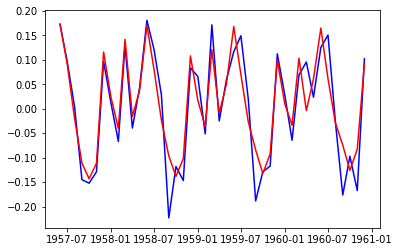

In [136]:
plt.plot(test,color="blue")
plt.plot(y_pred,color="red")

In [137]:
for i in range(0,10):
    print(test[i],y_pred[i])

0.17288752456059608 0.17239674275376926
0.09703209155134385 0.09200250123473443
0.004291852081541592 -0.01964007695993273
-0.144914379707747 -0.11090106226604436
-0.1520900980142912 -0.14297835428160066
-0.12901300333944743 -0.11165119811910797
0.0967993833557923 0.11575934449451114
0.011834457647003305 0.02374120216186343
-0.06689423483003054 -0.040264722434765934
0.12959282904559455 0.14199282098626853


# ARIMA



In [140]:
train.size,test.size

(99, 43)

In [143]:
from statsmodels.tsa.arima_model import ARIMA
arima_model=ARIMA(train,order=(2,0,3))
arima_model_fit=arima_model.fit()
arima_predict=arima_model_fit.forecast(steps=43)[0] #values
#arima_predict
print(arima_model_fit.aic)

-191.8657147609348


In [144]:
np.sqrt(mean_squared_error(test,arima_predict))

0.11243125001999366

In [145]:
#combnations of p,d,q  to check which is the best params combination which gives low AIC
import itertools
p=d=q=range(0,4)
pdq=list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 3, 0),
 (3, 3, 1),
 (3, 3, 2),
 (3, 3, 3)]

In [146]:
import warnings
warnings.filterwarnings("ignore")

In [147]:
for param in pdq:
    try:
        arima_model=ARIMA(train,order=param)
        arima_model_fit=arima_model.fit()
        print(param,arima_model_fit.aic)
    except:
        continue

    

(0, 0, 0) -165.8341883249032
(0, 0, 1) -166.62543681393714
(0, 0, 2) -180.95237469689317
(0, 0, 3) -183.96321325620733
(0, 1, 0) -110.17065201292394
(0, 1, 1) -156.53281427920234
(0, 1, 2) -157.67524397034953
(0, 1, 3) -166.69207041887415
(0, 2, 0) -14.053808804549078
(0, 2, 1) -101.44620401248494
(1, 0, 0) -165.7026501994402
(1, 0, 1) -177.1087858819464
(1, 0, 2) -186.99309378871015
(1, 0, 3) -185.00478035324147
(1, 1, 0) -118.97275651907415
(1, 1, 1) -156.68833537021465
(1, 1, 2) -160.46279852657693
(1, 1, 3) -158.51385798916158
(1, 2, 0) -46.322048716363156
(1, 2, 1) -109.58186018531273
(2, 0, 0) -167.00596215504066
(2, 0, 1) -188.7116980899561
(2, 0, 2) -193.38386893886025
(2, 0, 3) -191.8657147609348
(2, 1, 0) -129.2074052404942
(2, 1, 1) -157.63618582488402
(2, 1, 2) -158.5020415571546
(2, 1, 3) -170.4084605033599
(2, 2, 0) -78.3147239913672
(2, 2, 1) -119.11575959692993
(2, 2, 2) -117.13122499107703
(2, 2, 3) -132.39386501433114
(3, 0, 0) -165.39376481225372
(3, 0, 1) -187.82139

In [151]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test,arima_predict))

0.11243125001999366